In [1]:
#Import all the necessary packages and functions necessary for scripting
import sys
from pathlib import Path
import pandas 
import numpy as np

#Add the code folder to path
parent = str(Path(sys.path[0]).parent.absolute()) + r"\Code"
if parent not in sys.path:
    sys.path.append(parent)

from FDM_Newton_Solver import FDM_Solver
from FDM_derivs import derivGenerator

%matplotlib inline

In [2]:
#Define the shell's physical parameters and the simulation mesh size
L = 100 #Length in mm
r = 25 #100/(2*np.pi) #mean radius in mm
t = 0.1 #mean thickness in mm
nu = 0.3 #poisson ratio

#Desired x and y grid spacing in mm
dx = 1
dy = 1
Lpnts = int(L/dx)+1
rpnts = int(2*np.pi*r/dy)

dx = L/(Lpnts-1)
dy = 2*np.pi*r/rpnts

X, Y = np.mgrid[0:L:(Lpnts)*1j, 0:2*np.pi*r-dy:rpnts*1j]

print("Spacing in the x direction: ", dx)
print("Spacing in the y direction: ", dy)

Spacing in the x direction:  1.0
Spacing in the y direction:  1.0005072145190423


In [3]:
#Generate randomized geometric imperfections 

np.random.seed(12353) #See the random number generator for testing

#Generate randomized radius imperfections with a normal distribution 
w0 = np.random.normal(0, t, (Lpnts, rpnts))

#Then define variations in the thickness profile with a normal distribution with mean t
t0 = np.random.normal(t, t/10, (Lpnts, rpnts))

#Since in real life materials are not jagged on very small length scales, we can lowpass filter the generated distributions
from scipy.fft import fftfreq, fft2, ifft2

def lowPassFFT(M, dx, dy, cutoff):
    xpnts, ypnts = M.shape
    
    xf = 2*np.pi*fftfreq(xpnts, dx)
    yf = 2*np.pi*fftfreq(ypnts, dy)
    
    Yf, Xf = np.meshgrid(yf, xf)
    
    M_fft = fft2(M)
    
    F = np.ones(M_fft.shape)
    F[np.where(np.sqrt(Xf**2 + Yf**2) > cutoff)] = 0
    
    M_fft = M_fft*F
    M_filt = np.real(ifft2(M_fft))
    
    return M_filt

cutoff = 10 #We set the cuttoff lengthscale to be 10 mm 

w0 = lowPassFFT(w0, dx, dy, 2*np.pi/cutoff)
t0 = lowPassFFT(t0, dx, dy, 2*np.pi/cutoff)

In [4]:
#The imperfections need to have both their amplitudes and their derivatives defined.
#First set the order of the finite different method derivative approximation
order_imps = 3
dgen = derivGenerator(order_imps, dx, dy, X.shape[0])

#Then compute and store all the required derivatives
w0_derivs = np.zeros((6, Lpnts, rpnts))
w0_derivs[0] = w0
w0_derivs[1] = dgen.deriv(w0, 1, 0) #Take the first x derivative
w0_derivs[2] = dgen.deriv(w0, 0, 1) #Take the first y derivative
w0_derivs[3] = dgen.deriv(w0, 2, 0) #Take the second x derivative
w0_derivs[4] = dgen.deriv(w0, 1, 1) #Take the first x and y derivative
w0_derivs[5] = dgen.deriv(w0, 0, 2) #Take the second y derivative

t_derivs = np.zeros((6, Lpnts, rpnts))
t_derivs[0] = t0
t_derivs[1] = dgen.deriv(t0, 1, 0) #Take the first x derivative
t_derivs[2] = dgen.deriv(t0, 0, 1) #Take the first y derivative
t_derivs[3] = dgen.deriv(t0, 2, 0) #Take the second x derivative
t_derivs[4] = dgen.deriv(t0, 1, 1) #Take the first x and y derivative
t_derivs[5] = dgen.deriv(t0, 0, 2) #Take the second y derivative

In [15]:
#Initialize a solver for the specified shell

#Specify the order of the numerical derivative approximation for the simulation. 
#Higher order approximations will be more accurate but also slower
order_sim = 3

#Create the solver object
solver = FDM_Solver(r, L, nu, w0_derivs, t_derivs, order = order_sim)

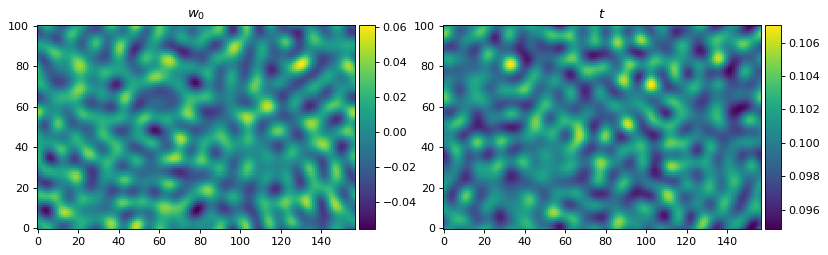

In [16]:
#Plot the imperfections
solver.plotImps()

Iteration 1 error: 9.184391844884962e-12
Computing this load took 7.524741888046265 seconds.


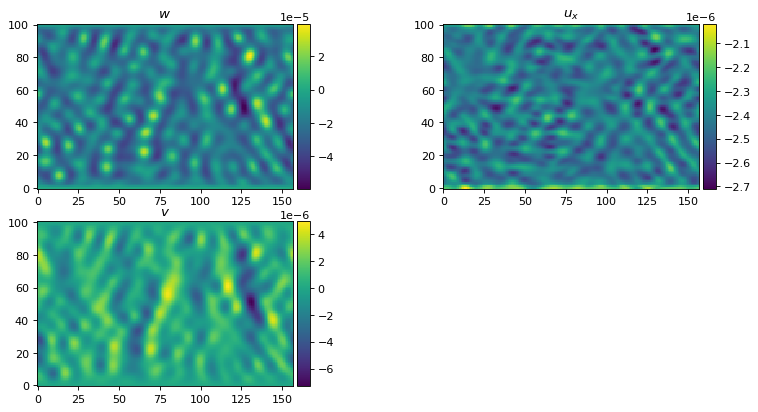

In [20]:
#First, lets get the deformation pattern for a single end displacement. 
#A perfect cylindrical shells buckles at when the end displacement reaches the following value
disp_cr = -L*t/(r*np.sqrt(3-3*nu**2))

#Lets compute the deformation pattern when the end dispalcement is 10% of this critical end displacement
end_disp = 0.1*disp_cr
w, u, v = solver.solve_single_disp(end_disp)

solver.plotDisp(w, u, v)

In [21]:
#Solve for the critical end displacement and critical load
disps, ws, us, vs = solver.solve_critical_disp()

Current load is: 0.41954479217529295
Current dl iter is: 10.0/10
Iteration 2 error: 9.87672415839622e-10
Simulation complete. Took: 250.80137634277344 seconds.


In [27]:
#Next lets do some analysis for a single load/frame. 
#In particular, let's take the last frame, the one corresponding to the state of the shell as it's about to buckle
load_int = -1

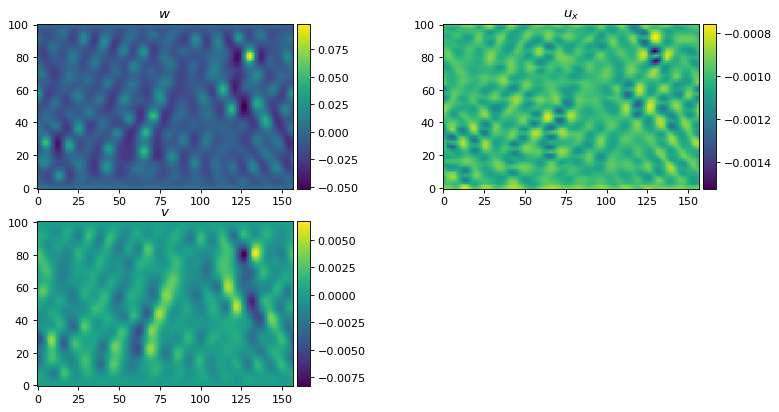

In [28]:
#We can plot the displacements
solver.plotDisp(ws[load_int], us[load_int], vs[load_int])

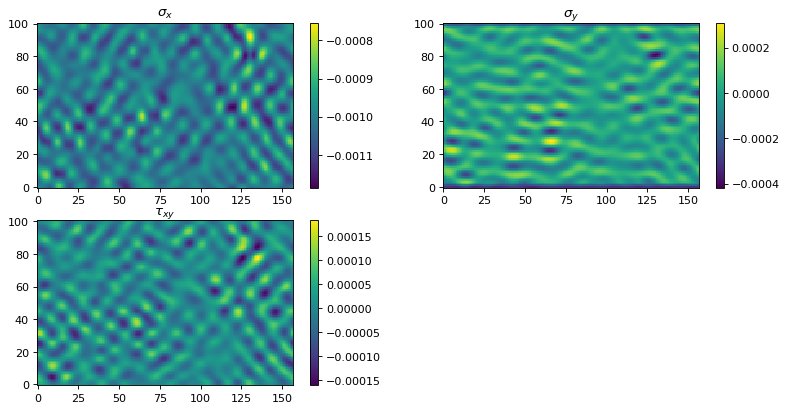

In [29]:
#And the stresses associated with those displacements
solver.plotStress(ws[load_int], us[load_int], vs[load_int])

In [30]:
#We can compute the eigenmodes and their associated eigenvalues
vals, w_modes, u_modes, v_modes = solver.calc_n_eigenmodes(ws[load_int], us[load_int], vs[load_int], 20)

Starting Arnoldi
Arnoldi iteration done in time:  9.532498121261597


In [31]:
#We see that the smallest eigenvalue is much closer to zero than any other eigenvalues
#This means this eigenmode is the buckling mode of the shell. 
print(vals)

[ 1.37944519e-09  3.19002629e-07  3.26839701e-07  3.59477765e-07
  3.82189173e-07  4.57536611e-07  4.70646598e-07  6.84682208e-07
  7.55516353e-07  8.41148479e-07  9.76222814e-07  1.30933687e-06
  1.67394712e-06  2.09718057e-06  3.21681260e-06  5.12771597e-06
  1.05006624e-05  2.01171185e-04 -3.70375808e-04 -3.77314556e-05]


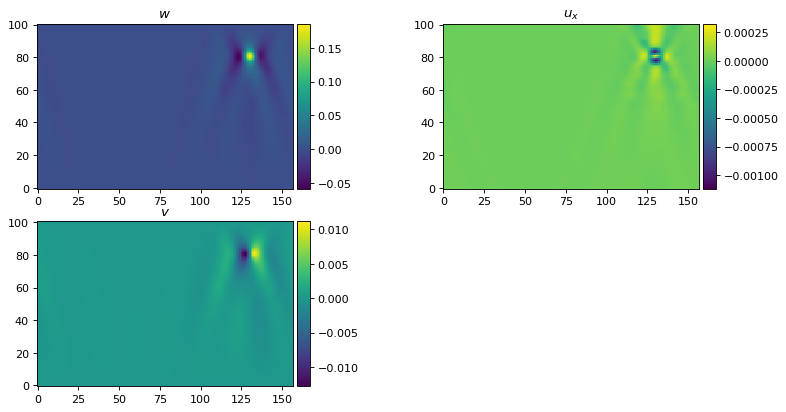

In [32]:
#We can plot the buckling mode
mode_num = 0
solver.plotDisp(np.real(w_modes[mode_num]), np.real(u_modes[mode_num]), np.real(v_modes[mode_num]))